# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("CartPole-v0").env

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-05-01 19:06:23,335] Making new env: CartPole-v0


In [3]:
#plt.imshow(env.render("rgb_array"))
#del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 50, nonlinearity=elu)
#nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-05-01 19:06:28,013] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-05-01 19:06:36,696] Making new env: CartPole-v0


In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[0 1 1 0 0]]
rewards: [[ 1.  1.  1.  1.  0.]]
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.71 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-3)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2017-05-01 19:06:45,230] Making new env: CartPole-v0
[2017-05-01 19:06:45,232] Creating monitor directory ./records
[2017-05-01 19:06:45,257] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 70 timesteps with reward=70.0


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

[2017-04-29 23:10:19,191] An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



IndexError: list index out of range

# Training loop

In [15]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 300

In [16]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 98/10000 [00:01<03:18, 49.84it/s][2017-05-01 19:06:55,061] Making new env: CartPole-v0
[2017-05-01 19:06:55,063] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:06:55,080] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  1%|          | 108/10000 [00:02<03:27, 47.59it/s]

Episode finished after 22 timesteps with reward=22.0
Episode finished after 17 timesteps with reward=17.0
Episode finished after 16 timesteps with reward=16.0
iter=100	epsilon=0.910
Current score(mean over 3) = 18.333


  2%|▏         | 198/10000 [00:04<03:21, 48.53it/s][2017-05-01 19:06:57,129] Making new env: CartPole-v0
[2017-05-01 19:06:57,131] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:06:57,149] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  2%|▏         | 208/10000 [00:04<03:30, 46.53it/s]

Episode finished after 25 timesteps with reward=25.0
Episode finished after 19 timesteps with reward=19.0
Episode finished after 18 timesteps with reward=18.0
iter=200	epsilon=0.828
Current score(mean over 3) = 20.667


  3%|▎         | 298/10000 [00:06<03:22, 47.91it/s][2017-05-01 19:06:59,231] Making new env: CartPole-v0
[2017-05-01 19:06:59,233] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:06:59,253] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  3%|▎         | 308/10000 [00:06<03:32, 45.61it/s]

Episode finished after 16 timesteps with reward=16.0
Episode finished after 36 timesteps with reward=36.0
Episode finished after 16 timesteps with reward=16.0
iter=300	epsilon=0.754
Current score(mean over 3) = 22.667


  4%|▍         | 398/10000 [00:08<03:46, 42.48it/s][2017-05-01 19:07:01,540] Making new env: CartPole-v0
[2017-05-01 19:07:01,541] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:01,558] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  4%|▍         | 403/10000 [00:08<03:57, 40.48it/s]

Episode finished after 13 timesteps with reward=13.0
Episode finished after 15 timesteps with reward=15.0
Episode finished after 27 timesteps with reward=27.0
iter=400	epsilon=0.687
Current score(mean over 3) = 18.333


  5%|▍         | 498/10000 [00:10<03:46, 41.87it/s][2017-05-01 19:07:03,936] Making new env: CartPole-v0
[2017-05-01 19:07:03,938] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:03,978] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  5%|▌         | 503/10000 [00:10<04:11, 37.82it/s]

Episode finished after 36 timesteps with reward=36.0
Episode finished after 41 timesteps with reward=41.0
Episode finished after 63 timesteps with reward=63.0
iter=500	epsilon=0.626
Current score(mean over 3) = 46.667


  6%|▌         | 598/10000 [00:13<03:48, 41.14it/s][2017-05-01 19:07:06,395] Making new env: CartPole-v0
[2017-05-01 19:07:06,396] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:06,445] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  6%|▌         | 603/10000 [00:13<04:17, 36.53it/s]

Episode finished after 74 timesteps with reward=74.0
Episode finished after 76 timesteps with reward=76.0
Episode finished after 17 timesteps with reward=17.0
iter=600	epsilon=0.571
Current score(mean over 3) = 55.667


  7%|▋         | 698/10000 [00:15<03:56, 39.36it/s][2017-05-01 19:07:08,942] Making new env: CartPole-v0
[2017-05-01 19:07:08,944] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:08,997] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  7%|▋         | 702/10000 [00:15<04:34, 33.87it/s]

Episode finished after 53 timesteps with reward=53.0
Episode finished after 57 timesteps with reward=57.0
Episode finished after 78 timesteps with reward=78.0
iter=700	epsilon=0.522
Current score(mean over 3) = 62.667


  8%|▊         | 799/10000 [00:18<03:50, 39.84it/s][2017-05-01 19:07:11,495] Making new env: CartPole-v0
[2017-05-01 19:07:11,496] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:11,541] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  8%|▊         | 803/10000 [00:18<04:23, 34.84it/s]

Episode finished after 60 timesteps with reward=60.0
Episode finished after 62 timesteps with reward=62.0
Episode finished after 33 timesteps with reward=33.0
iter=800	epsilon=0.477
Current score(mean over 3) = 51.667


  9%|▉         | 899/10000 [00:20<03:51, 39.25it/s][2017-05-01 19:07:14,078] Making new env: CartPole-v0
[2017-05-01 19:07:14,080] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:14,117] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  9%|▉         | 903/10000 [00:21<04:18, 35.16it/s]

Episode finished after 28 timesteps with reward=28.0
Episode finished after 52 timesteps with reward=52.0
Episode finished after 46 timesteps with reward=46.0
iter=900	epsilon=0.436
Current score(mean over 3) = 42.000


 10%|▉         | 999/10000 [00:23<03:51, 38.83it/s][2017-05-01 19:07:16,691] Making new env: CartPole-v0
[2017-05-01 19:07:16,692] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:16,725] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 10%|█         | 1003/10000 [00:23<04:15, 35.18it/s]

Episode finished after 26 timesteps with reward=26.0
Episode finished after 39 timesteps with reward=39.0
Episode finished after 50 timesteps with reward=50.0
iter=1000	epsilon=0.399
Current score(mean over 3) = 38.333


 11%|█         | 1099/10000 [00:26<03:53, 38.09it/s][2017-05-01 19:07:19,337] Making new env: CartPole-v0
[2017-05-01 19:07:19,339] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:19,384] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 11%|█         | 1103/10000 [00:26<04:24, 33.60it/s]

Episode finished after 56 timesteps with reward=56.0
Episode finished after 59 timesteps with reward=59.0
Episode finished after 40 timesteps with reward=40.0
iter=1100	epsilon=0.366
Current score(mean over 3) = 51.667


 12%|█▏        | 1199/10000 [00:28<03:52, 37.77it/s][2017-05-01 19:07:22,023] Making new env: CartPole-v0
[2017-05-01 19:07:22,025] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:22,062] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 12%|█▏        | 1203/10000 [00:29<04:19, 33.85it/s]

Episode finished after 59 timesteps with reward=59.0
Episode finished after 42 timesteps with reward=42.0
Episode finished after 30 timesteps with reward=30.0
iter=1200	epsilon=0.336
Current score(mean over 3) = 43.667


 13%|█▎        | 1299/10000 [00:31<03:54, 37.09it/s][2017-05-01 19:07:24,747] Making new env: CartPole-v0
[2017-05-01 19:07:24,749] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:24,805] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 13%|█▎        | 1303/10000 [00:31<04:32, 31.87it/s]

Episode finished after 55 timesteps with reward=55.0
Episode finished after 82 timesteps with reward=82.0
Episode finished after 62 timesteps with reward=62.0
iter=1300	epsilon=0.309
Current score(mean over 3) = 66.333


 14%|█▍        | 1396/10000 [00:33<03:19, 43.18it/s][2017-05-01 19:07:27,154] Making new env: CartPole-v0
[2017-05-01 19:07:27,156] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:27,272] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 14%|█▍        | 1406/10000 [00:34<04:02, 35.44it/s]

Episode finished after 269 timesteps with reward=269.0
Episode finished after 72 timesteps with reward=72.0
Episode finished after 76 timesteps with reward=76.0
iter=1400	epsilon=0.284
Current score(mean over 3) = 139.000


 15%|█▍        | 1496/10000 [00:36<03:19, 42.62it/s][2017-05-01 19:07:29,612] Making new env: CartPole-v0
[2017-05-01 19:07:29,613] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:29,694] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 15%|█▌        | 1506/10000 [00:36<03:50, 36.93it/s]

Episode finished after 89 timesteps with reward=89.0
Episode finished after 75 timesteps with reward=75.0
Episode finished after 125 timesteps with reward=125.0
iter=1500	epsilon=0.262
Current score(mean over 3) = 96.333


 16%|█▌        | 1596/10000 [00:38<03:21, 41.61it/s][2017-05-01 19:07:32,088] Making new env: CartPole-v0
[2017-05-01 19:07:32,090] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:32,178] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 16%|█▌        | 1601/10000 [00:39<04:07, 33.88it/s]

Episode finished after 102 timesteps with reward=102.0
Episode finished after 93 timesteps with reward=93.0
Episode finished after 121 timesteps with reward=121.0
iter=1600	epsilon=0.242
Current score(mean over 3) = 105.333


 17%|█▋        | 1696/10000 [00:41<03:22, 40.98it/s][2017-05-01 19:07:34,610] Making new env: CartPole-v0
[2017-05-01 19:07:34,612] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:34,749] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 17%|█▋        | 1701/10000 [00:41<04:32, 30.50it/s]

Episode finished after 244 timesteps with reward=244.0
Episode finished after 116 timesteps with reward=116.0
Episode finished after 130 timesteps with reward=130.0
iter=1700	epsilon=0.224
Current score(mean over 3) = 163.333


 18%|█▊        | 1796/10000 [00:44<03:21, 40.66it/s][2017-05-01 19:07:37,199] Making new env: CartPole-v0
[2017-05-01 19:07:37,201] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:37,331] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 18%|█▊        | 1801/10000 [00:44<04:27, 30.70it/s]

Episode finished after 129 timesteps with reward=129.0
Episode finished after 183 timesteps with reward=183.0
Episode finished after 157 timesteps with reward=157.0
iter=1800	epsilon=0.207
Current score(mean over 3) = 156.333


 19%|█▉        | 1895/10000 [00:46<03:22, 40.03it/s][2017-05-01 19:07:39,823] Making new env: CartPole-v0
[2017-05-01 19:07:39,824] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:39,965] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 19%|█▉        | 1900/10000 [00:46<04:32, 29.77it/s]

Episode finished after 130 timesteps with reward=130.0
Episode finished after 226 timesteps with reward=226.0
Episode finished after 142 timesteps with reward=142.0
iter=1900	epsilon=0.192
Current score(mean over 3) = 166.000


 20%|█▉        | 1996/10000 [00:49<03:24, 39.22it/s][2017-05-01 19:07:42,501] Making new env: CartPole-v0
[2017-05-01 19:07:42,502] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:42,648] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 20%|██        | 2005/10000 [00:49<04:23, 30.34it/s]

Episode finished after 249 timesteps with reward=249.0
Episode finished after 138 timesteps with reward=138.0
Episode finished after 135 timesteps with reward=135.0
iter=2000	epsilon=0.179
Current score(mean over 3) = 174.000


 21%|██        | 2095/10000 [00:51<03:13, 40.92it/s][2017-05-01 19:07:45,093] Making new env: CartPole-v0
[2017-05-01 19:07:45,095] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:45,275] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 21%|██        | 2100/10000 [00:52<04:39, 28.27it/s]

Episode finished after 245 timesteps with reward=245.0
Episode finished after 192 timesteps with reward=192.0
Episode finished after 208 timesteps with reward=208.0
iter=2100	epsilon=0.166
Current score(mean over 3) = 215.000


 22%|██▏       | 2195/10000 [00:54<03:10, 40.94it/s][2017-05-01 19:07:47,719] Making new env: CartPole-v0
[2017-05-01 19:07:47,720] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:47,849] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 22%|██▏       | 2200/10000 [00:54<04:11, 30.96it/s]

Episode finished after 154 timesteps with reward=154.0
Episode finished after 159 timesteps with reward=159.0
Episode finished after 146 timesteps with reward=146.0
iter=2200	epsilon=0.155
Current score(mean over 3) = 153.000


 23%|██▎       | 2295/10000 [00:57<03:08, 40.95it/s][2017-05-01 19:07:50,296] Making new env: CartPole-v0
[2017-05-01 19:07:50,297] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:50,427] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 23%|██▎       | 2300/10000 [00:57<04:09, 30.92it/s]

Episode finished after 155 timesteps with reward=155.0
Episode finished after 146 timesteps with reward=146.0
Episode finished after 163 timesteps with reward=163.0
iter=2300	epsilon=0.145
Current score(mean over 3) = 154.667


 24%|██▍       | 2395/10000 [00:59<03:04, 41.25it/s][2017-05-01 19:07:52,860] Making new env: CartPole-v0
[2017-05-01 19:07:52,862] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:52,990] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 24%|██▍       | 2400/10000 [00:59<04:03, 31.22it/s]

Episode finished after 148 timesteps with reward=148.0
Episode finished after 155 timesteps with reward=155.0
Episode finished after 156 timesteps with reward=156.0
iter=2400	epsilon=0.136
Current score(mean over 3) = 153.000


 25%|██▍       | 2495/10000 [01:02<03:02, 41.18it/s][2017-05-01 19:07:55,417] Making new env: CartPole-v0
[2017-05-01 19:07:55,418] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:55,569] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 25%|██▌       | 2500/10000 [01:02<04:11, 29.86it/s]

Episode finished after 165 timesteps with reward=165.0
Episode finished after 175 timesteps with reward=175.0
Episode finished after 206 timesteps with reward=206.0
iter=2500	epsilon=0.128
Current score(mean over 3) = 182.000


 26%|██▌       | 2595/10000 [01:04<03:00, 40.96it/s][2017-05-01 19:07:58,011] Making new env: CartPole-v0
[2017-05-01 19:07:58,013] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:07:58,165] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 26%|██▌       | 2600/10000 [01:05<04:09, 29.71it/s]

Episode finished after 177 timesteps with reward=177.0
Episode finished after 189 timesteps with reward=189.0
Episode finished after 182 timesteps with reward=182.0
iter=2600	epsilon=0.121
Current score(mean over 3) = 182.667


 27%|██▋       | 2699/10000 [01:07<02:58, 40.94it/s][2017-05-01 19:08:00,612] Making new env: CartPole-v0
[2017-05-01 19:08:00,614] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-01 19:08:00,780] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 27%|██▋       | 2704/10000 [01:07<04:12, 28.92it/s]

Episode finished after 243 timesteps with reward=243.0
Episode finished after 163 timesteps with reward=163.0
Episode finished after 192 timesteps with reward=192.0
iter=2700	epsilon=0.114
Current score(mean over 3) = 199.333


 28%|██▊       | 2799/10000 [01:10<02:56, 40.84it/s][2017-05-01 19:08:03,225] Making new env: CartPole-v0
[2017-05-01 19:08:03,226] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 204 timesteps with reward=204.0
Episode finished after 283 timesteps with reward=283.0


[2017-05-01 19:08:03,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 452 timesteps with reward=452.0
iter=2800	epsilon=0.108
Current score(mean over 3) = 313.000
You win!


In [36]:
pool.experience_replay.observations[0].get_value()[0]

array([[-0.09115407, -0.15741515, -0.17688504, -0.83037353],
       [-0.09430237, -0.34973556, -0.1934925 , -0.5981276 ],
       [-0.10129709, -0.15250808, -0.20545505, -0.9449805 ],
       [-0.10434724, -0.34435919, -0.22435467, -0.72323602],
       [ 0.02989943, -0.03761347, -0.01013596, -0.00807199],
       [ 0.02914716,  0.15765236, -0.01029739, -0.30393562],
       [ 0.03230021, -0.03732133, -0.01637611, -0.01451796],
       [ 0.03155379,  0.1580316 , -0.01666647, -0.31232244],
       [ 0.03471442,  0.35338697, -0.02291291, -0.61021447],
       [ 0.04178216,  0.15859267, -0.03511721, -0.32483554]], dtype=float32)

In [35]:
pool.experience_replay.observations[0].get_value()[1]

array([[ 0.04178216,  0.15859267, -0.03511721, -0.32483554],
       [ 0.04495401,  0.35419658, -0.04161391, -0.62838286],
       [ 0.05203794,  0.15967935, -0.05418157, -0.34909058],
       [ 0.05523153, -0.03463181, -0.06116338, -0.07397313],
       [ 0.05453889,  0.16131122, -0.06264285, -0.38530892],
       [ 0.05776512, -0.03286806, -0.07034902, -0.11301624],
       [ 0.05710775,  0.16318771, -0.07260935, -0.42703804],
       [ 0.06037151, -0.03083476, -0.08115011, -0.15809959],
       [ 0.05975481,  0.1653496 , -0.0843121 , -0.47523966],
       [ 0.0630618 ,  0.36155462, -0.0938169 , -0.79326016]], dtype=float32)

In [24]:
r = pool.interact()

/home/shmuma/anaconda3/envs/pract_rl/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


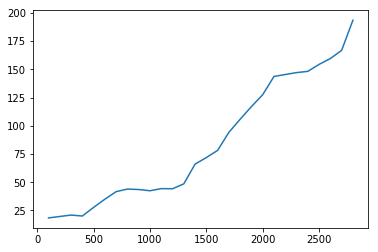

 28%|██▊       | 2799/10000 [01:30<03:51, 31.07it/s]

In [17]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda t: t[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [ ]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

## Homework part I (5+ pts)

Train a neural network for [`LunarLander-v2`](https://gym.openai.com/envs/LunarLander-v2).
* Getting average reward of at least +0 gets you 5 points
* Higher reward = more points


## Bonus I
* Try getting the same [or better] results on Acrobot __(+2 pts)__ or __LunarLander (+3 pts)__ using on-policy methods
* You can get n-step q-learning by messing with ```n_steps``` param in the q-learning code above
* Note that using large experience replay buffer will slow down on-policy algorithms to almost zero, so it's probably a good idea to use small experience replay buffer with several parallel agents